In [27]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from scipy.stats import uniform, loguniform

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import time

# **Loading Dataset**

In [2]:
# Load data in chunks to manage memory
chunk_size = 100000
chunks = pd.read_json("/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json", lines=True, chunksize=chunk_size)
df = pd.concat(chunks, ignore_index=True)

In [3]:
df.shape

(2730173, 14)

# **Data Exploration and Visualization**

## **Data Inspection**

In [4]:
print("Shape of dataset:", df.shape,'\n')
print("info about dataset: ",df.info(),"\n")
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (2730173, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730173 entries, 0 to 2730172
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 291.6+ MB
info about dataset:  None 


Missing values:
 id                      0
submitter           15189
authors                 0
title                   0
comments           711053
journal-ref       1838801
doi               1490986
report-no         2545011
categories              0
license            452785
abstract                0
versions                0
upda

## **Visualization**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


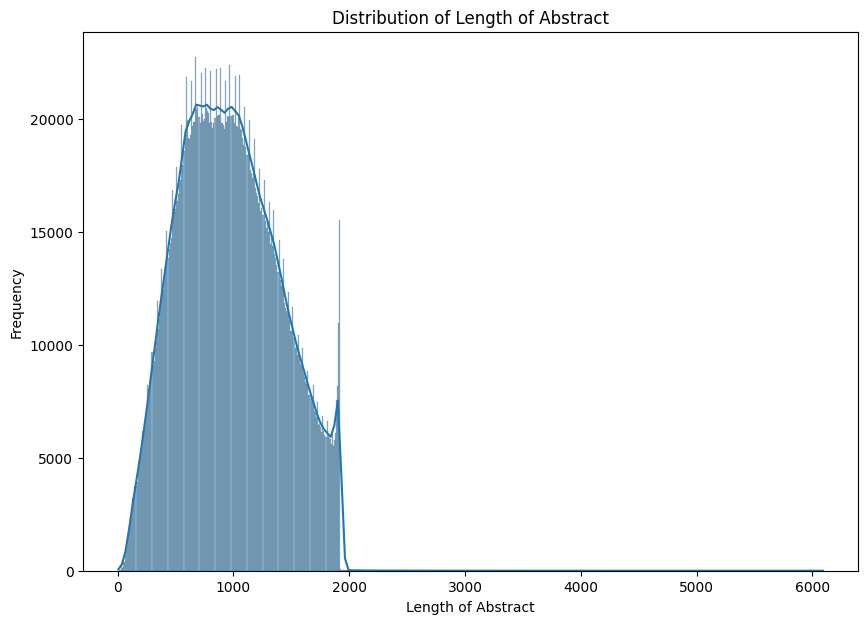

In [5]:
# get Lenth of Text.
df['len_text'] = df['abstract'].apply(len)
df['len_text'].head()

plt.figure(figsize=(10, 7))  # Corrected from "figuer" to "figure"
plt.title("Distribution of Length of Abstract")  # Fixed spelling of "Distrbution" and "Lenth"
sns.histplot(df['len_text'], kde=True)  # Pass just the Series, not x=df['len_text']
plt.xlabel("Length of Abstract")
plt.ylabel("Frequency")
plt.show()

## **Check Balance**

In [6]:
fillter = df['categories'].value_counts().head(10)

In [7]:
dfff = df.copy()

In [8]:
def balance_data(df, filter_counts):
    valid_categories = [cat for cat, count in filter_counts.items() if  count > 10000]
    return df[df['categories'].isin(valid_categories)]


In [9]:
dff = balance_data(df,fillter)
df= dff
dff.shape

(556875, 15)

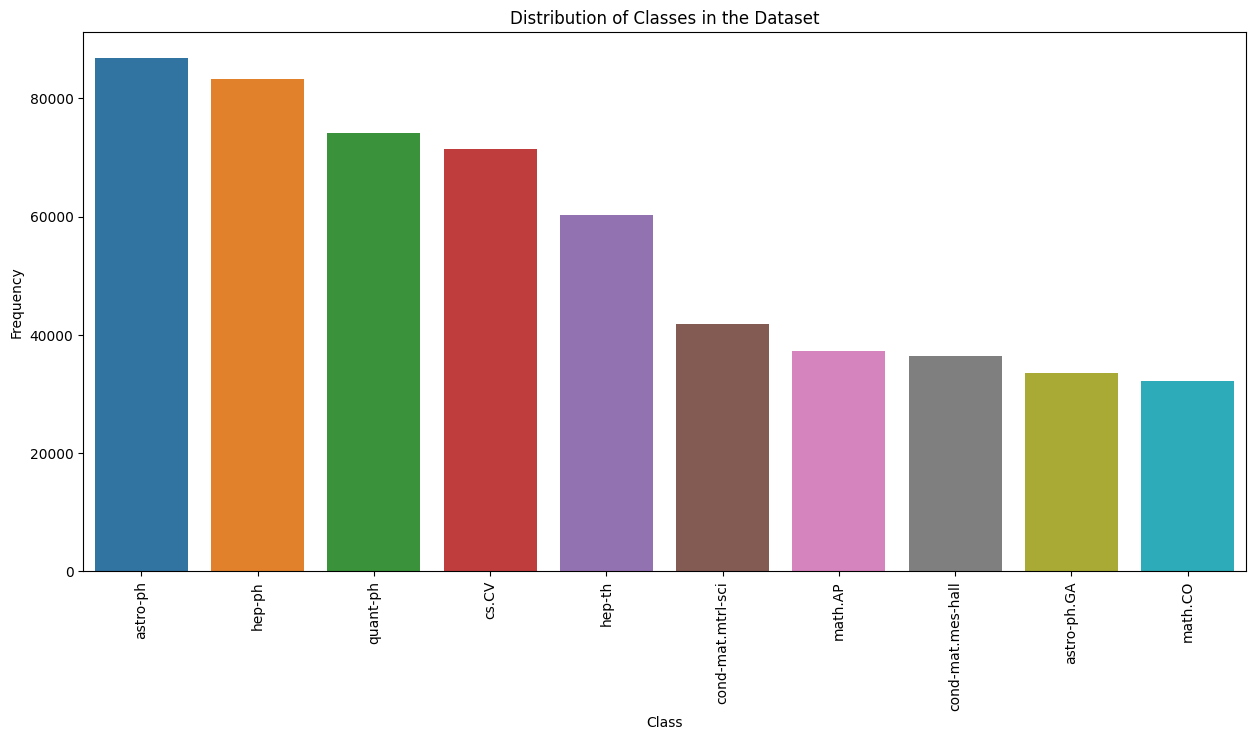

In [10]:
#Distribution of Class of Dataset.

plt.figure(figsize=(15, 7))
plt.title("Distribution of Classes in the Dataset")
sns.countplot(data=df, x='categories', order=df['categories'].value_counts().index)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

## **Word cloud**

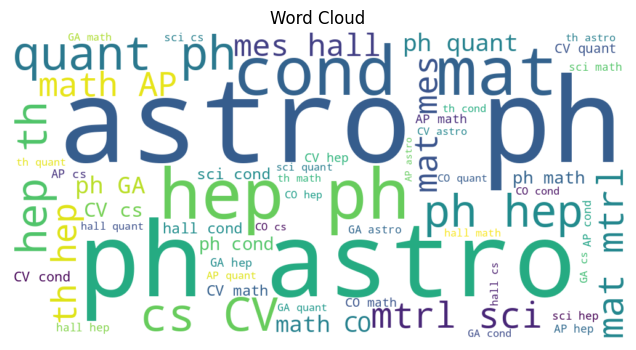

In [11]:
from wordcloud import WordCloud

all_text = ' '.join(df['categories'])

wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=1000).generate(all_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [12]:
print("Shape of dataset:", df.shape,'\n')
print("info about dataset: ",df.info(),"\n")
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (556875, 15) 

<class 'pandas.core.frame.DataFrame'>
Index: 556875 entries, 0 to 2729259
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              556875 non-null  object
 1   submitter       548861 non-null  object
 2   authors         556875 non-null  object
 3   title           556875 non-null  object
 4   comments        454735 non-null  object
 5   journal-ref     226665 non-null  object
 6   doi             318818 non-null  object
 7   report-no       65242 non-null   object
 8   categories      556875 non-null  object
 9   license         367782 non-null  object
 10  abstract        556875 non-null  object
 11  versions        556875 non-null  object
 12  update_date     556875 non-null  object
 13  authors_parsed  556875 non-null  object
 14  len_text        556875 non-null  int64 
dtypes: int64(1), object(14)
memory usage: 68.0+ MB
info about dataset:  None 


Missing values

# **Data Preprocessing**

## **Text Cleaning**

In [13]:
df.drop(['report-no','id','journal-ref','doi'], axis=1, inplace=True)
df['comments'].fillna('No Comments')
df['submitter'].fillna('Prefer not to say')
df['license'].fillna('None')

0                                                       None
3                                                       None
5                                                       None
7          http://arxiv.org/licenses/nonexclusive-distrib...
8                                                       None
                                 ...                        
2729254                                                 None
2729255                                                 None
2729257                                                 None
2729258                                                 None
2729259                                                 None
Name: license, Length: 556875, dtype: object

In [15]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [16]:
texts = list(df['abstract'])

In [17]:
df['Cleaned_abstract'] = df['abstract'].apply(process_text)

In [18]:
X = df['Cleaned_abstract']
y = df['categories']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

# **Feature Engineering**


In [20]:
X_train = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_train]
X_test = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_test]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# **Build Models**


=== Logistic Regression ===
Accuracy: 0.9324444444444444
Classification Report:
                   precision    recall  f1-score   support

         astro-ph       0.90      0.94      0.92     17361
      astro-ph.GA       0.88      0.77      0.82      6713
cond-mat.mes-hall       0.84      0.82      0.83      7414
cond-mat.mtrl-sci       0.87      0.87      0.87      8187
            cs.CV       0.99      1.00      0.99     14266
           hep-ph       0.96      0.95      0.95     16727
           hep-th       0.93      0.94      0.93     12015
          math.AP       0.98      0.98      0.98      7411
          math.CO       0.98      0.99      0.98      6472
         quant-ph       0.94      0.95      0.95     14809

         accuracy                           0.93    111375
        macro avg       0.93      0.92      0.92    111375
     weighted avg       0.93      0.93      0.93    111375


=== Naive Bayes ===
Accuracy: 0.8840852974186307
Classification Report:
                 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-12 11:47:59.265343: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
2785/2785 ━━━━━━━━━━━━━━━━━━━━ 1801s 644ms/step - accuracy: 0.1526 - loss: 2.2391 - val_accuracy: 0.1552 - val_loss: 2.2346
Epoch 2/20
2785/2785 ━━━━━━━━━━━━━━━━━━━━ 1860s 668ms/step - accuracy: 0.1548 - loss: 2.2324 - val_accuracy: 0.1552 - val_loss: 2.2341
Epoch 3/20
2785/2785 ━━━━━━━━━━━━━━━━━━━━ 1825s 655ms/step - accuracy: 0.1567 - loss: 2.2336 - val_accuracy: 0.1552 - val_loss: 2.2342
Epoch 4/20
2785/2785 ━━━━━━━━━━━━━━━━━━━━ 1867s 671ms/step - accuracy: 0.1565 - loss: 2.2322 - val_accuracy: 0.1552 - val_loss: 2.2342
Epoch 5/20
2785/2785 ━━━━━━━━━━━━━━━━━━━━ 1919s 689ms/step - accuracy: 0.1566 - loss: 2.2332 - val_accuracy: 0.1552 - val_loss: 2.2341
3481/3481 ━━━━━━━━━━━━━━━━━━━━ 372s 107ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Recurrent Neural Network (RNN) ===
Accuracy: 0.15587878787878787
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

         astro-ph       0.16      1.00      0.27     17361
      astro-ph.GA       0.00      0.00      0.00      6713
cond-mat.mes-hall       0.00      0.00      0.00      7414
cond-mat.mtrl-sci       0.00      0.00      0.00      8187
            cs.CV       0.00      0.00      0.00     14266
           hep-ph       0.00      0.00      0.00     16727
           hep-th       0.00      0.00      0.00     12015
          math.AP       0.00      0.00      0.00      7411
          math.CO       0.00      0.00      0.00      6472
         quant-ph       0.00      0.00      0.00     14809

         accuracy                           0.16    111375
        macro avg       0.02      0.10      0.03    111375
     weighted avg       0.02      0.16      0.04    111375



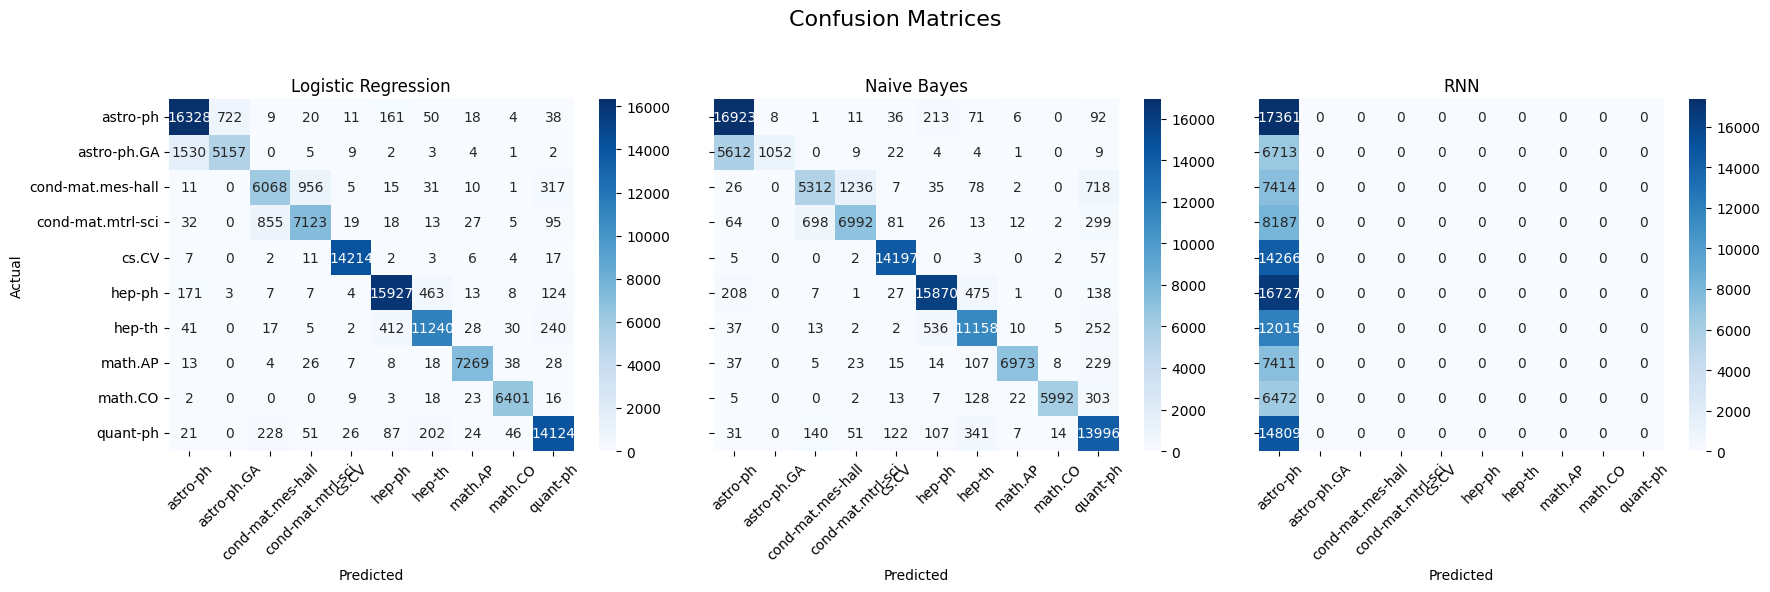

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


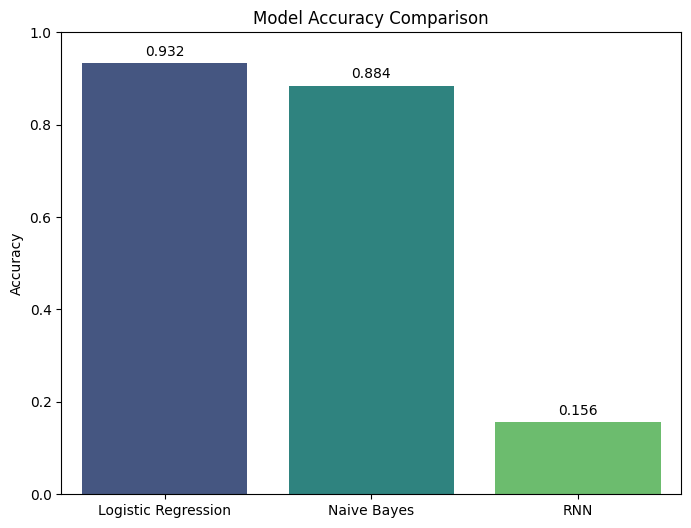

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


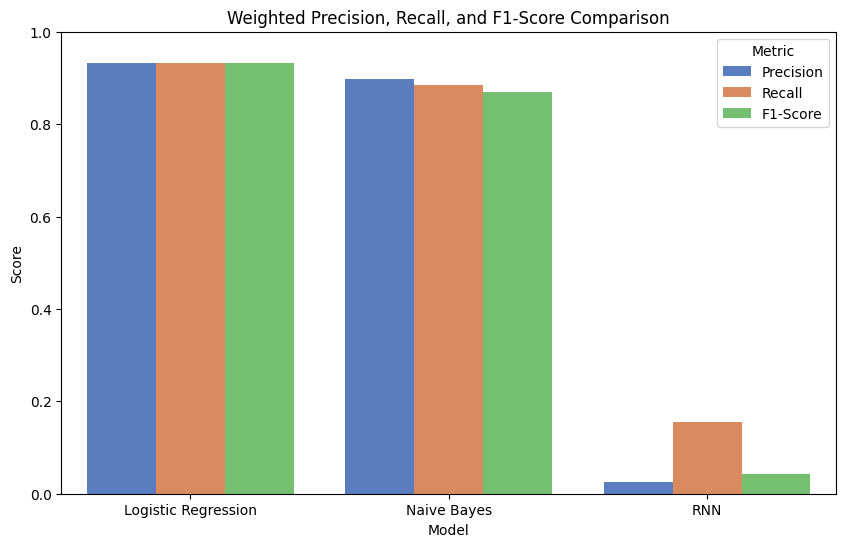

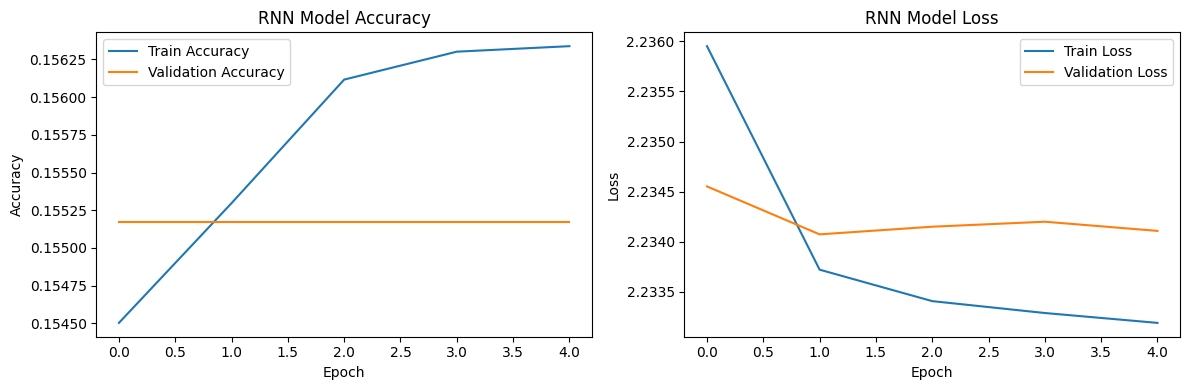

In [ ]:
max_words = 10000
max_len = 200
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# 5. Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_y_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_report = classification_report(y_test, lr_y_pred, output_dict=True)

print("\n=== Logistic Regression ===")
print("Accuracy:", lr_accuracy)
print("Classification Report:")
print(classification_report(y_test, lr_y_pred))

# 6. Train and evaluate Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_y_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred, output_dict=True)

print("\n=== Naive Bayes ===")
print("Accuracy:", nb_accuracy)
print("Classification Report:")
print(classification_report(y_test, nb_y_pred))

# 7. Train and evaluate RNN
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Train RNN
history = rnn_model.fit(
    X_train_pad,
    y_train_enc,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate RNN
rnn_y_pred_prob = rnn_model.predict(X_test_pad)
rnn_y_pred_enc = np.argmax(rnn_y_pred_prob, axis=1)
rnn_y_pred = label_encoder.inverse_transform(rnn_y_pred_enc)
rnn_accuracy = accuracy_score(y_test, rnn_y_pred)
rnn_report = classification_report(y_test, rnn_y_pred, output_dict=True)

print("\n=== Recurrent Neural Network (RNN) ===")
print("Accuracy:", rnn_accuracy)
print("Classification Report:")
print(classification_report(y_test, rnn_y_pred))

# 8. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Confusion Matrices", fontsize=16)

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].tick_params(axis='x', rotation=45)

# Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].tick_params(axis='x', rotation=45)

# RNN
rnn_cm = confusion_matrix(y_test, rnn_y_pred)
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[2].set_title("RNN")
axes[2].set_xlabel("Predicted")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 9. Bar Plot of Model Accuracies
model_names = ['Logistic Regression', 'Naive Bayes', 'RNN']
accuracies = [lr_accuracy, nb_accuracy, rnn_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom')
plt.show()

# 10. Precision, Recall, F1-Score Bar Plot
lr_metrics = precision_recall_fscore_support(y_test, lr_y_pred, average='weighted')
nb_metrics = precision_recall_fscore_support(y_test, nb_y_pred, average='weighted')
rnn_metrics = precision_recall_fscore_support(y_test, rnn_y_pred, average='weighted')

metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'RNN'] * 3,
    'Metric': ['Precision'] * 3 + ['Recall'] * 3 + ['F1-Score'] * 3,
    'Score': [lr_metrics[0], nb_metrics[0], rnn_metrics[0],  # Precision
              lr_metrics[1], nb_metrics[1], rnn_metrics[1],  # Recall
              lr_metrics[2], nb_metrics[2], rnn_metrics[2]]  # F1-Score
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette='muted')
plt.title("Weighted Precision, Recall, and F1-Score Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()

# 11. Plot RNN training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Using Grid Search

In [25]:
sample_size = 50000
if X_train_tfidf.shape[0] > sample_size:
    from sklearn.utils import resample
    indices = np.random.choice(X_train_tfidf.shape[0], sample_size, replace=False)
    X_train_tfidf_sample = X_train_tfidf[indices]
    y_train_sample = y_train.iloc[indices]
else:
    X_train_tfidf_sample = X_train_tfidf
    y_train_sample = y_train

# 4. Grid Search for Logistic Regression
print("=== Logistic Regression Tuning ===")
lr_param_dist = {
    'C': loguniform(0.01, 10),
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}
lr_model = LogisticRegression(multi_class='multinomial')
lr_search = RandomizedSearchCV(
    lr_model,
    param_distributions=lr_param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
start_time = time.time()
lr_search.fit(X_train_tfidf_sample, y_train_sample)
print(f"Logistic Regression Tuning Time: {time.time() - start_time:.2f} seconds")
print("Best Parameters:", lr_search.best_params_)
print("Best CV Accuracy:", lr_search.best_score_)

# Train best model on full data
best_lr_model = lr_search.best_estimator_
best_lr_model.fit(X_train_tfidf, y_train)
lr_y_pred = best_lr_model.predict(X_test_tfidf)

# Evaluate
print("\nLogistic Regression Test Performance")
print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("Classification Report:\n", classification_report(y_test, lr_y_pred))

=== Logistic Regression Tuning ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression Tuning Time: 389.66 seconds
Best Parameters: {'C': 3.142880890840109, 'max_iter': 1000, 'solver': 'saga'}
Best CV Accuracy: 0.91496

Logistic Regression Test Performance
Accuracy: 0.9340516273849607
Classification Report:
                    precision    recall  f1-score   support

         astro-ph       0.90      0.94      0.92     17361
      astro-ph.GA       0.87      0.78      0.82      6713
cond-mat.mes-hall       0.84      0.82      0.83      7414
cond-mat.mtrl-sci       0.87      0.87      0.87      8187
            cs.CV       0.99      1.00      1.00     14266
           hep-ph       0.96      0.96      0.96     16727
           hep-th       0.94      0.94      0.94     12015
          math.AP       0.98      0.98      0.98      7411
          math.CO       0.98      0.99      0.99      6472
         quant-ph       0.95      0.95      0.95     14809

         a

# Save Model

In [ ]:
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
rnn_model.save('rnn_model.keras')
joblib.dump(best_lr_model, 'best_lr_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')